In [1]:
# ========
# Packages
# ========

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import textwrap
import glob
import scipy.interpolate
import datetime
import os

plt.rcParams.update({'font.size': 17})


In [2]:
# =========================
# *******   NOTE   *******
# =========================
#  Only 'data' and 'vers'
# have to be updated by the
#  user in this notebook
# =========================

# Provide the path on your local machine to the Pandeia data directory
data = '/Users/bholler/Documents/pandeia_data-4.0'
path = data + '/jwst/'

# Provide the version of the associated Pandeia data files
vers = '4.0'

# =========================

# Determine the date of the creation of the files
dt = datetime.datetime.now()
date = dt.strftime('%B') + ' ' + dt.strftime('%d') + ', ' + dt.strftime('%Y')

# Determine the current working directory
cwd = os.getcwd()


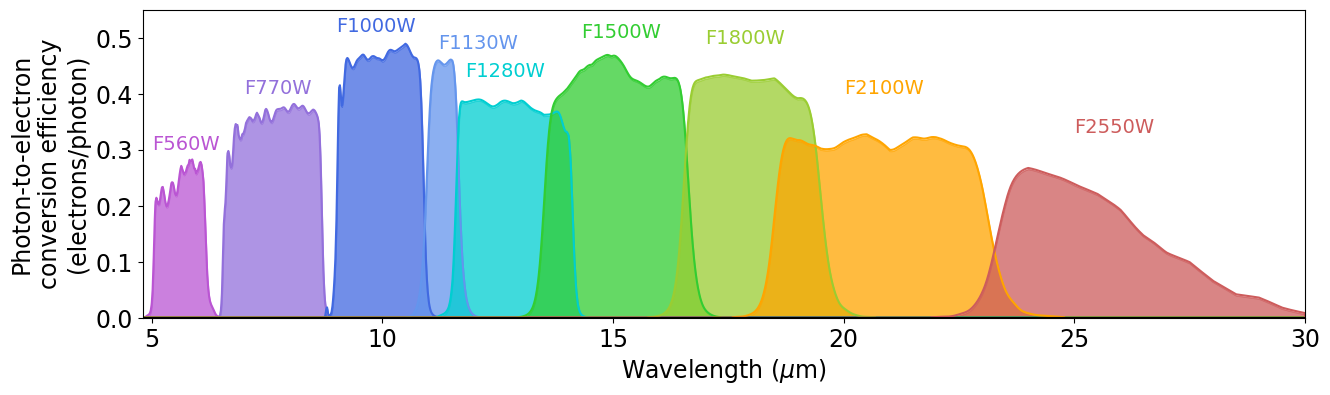

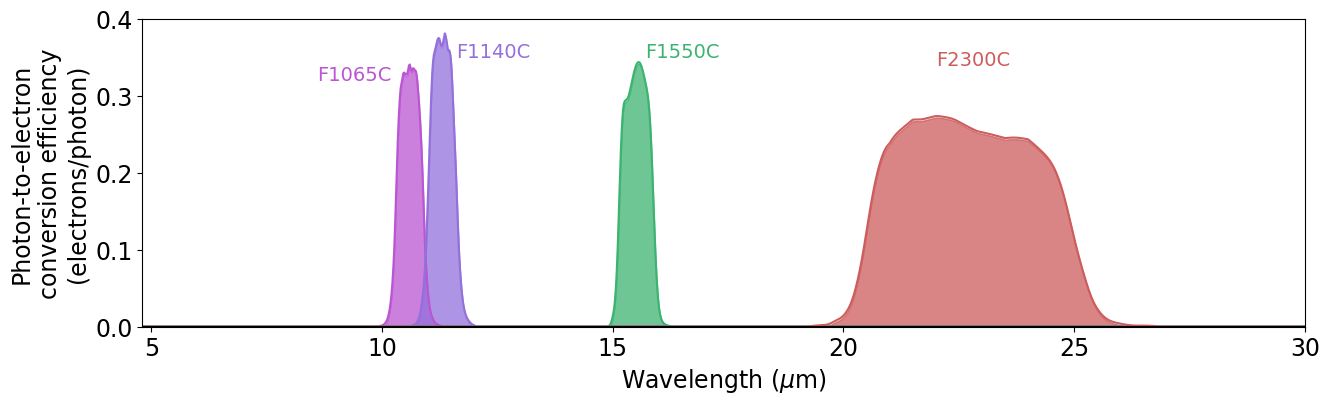

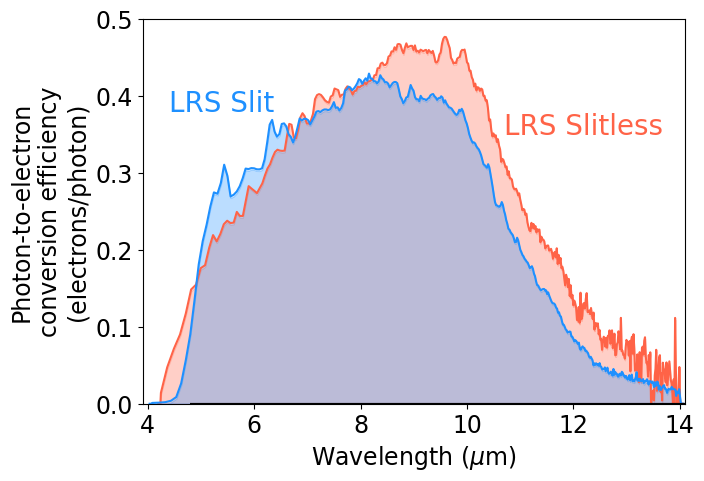

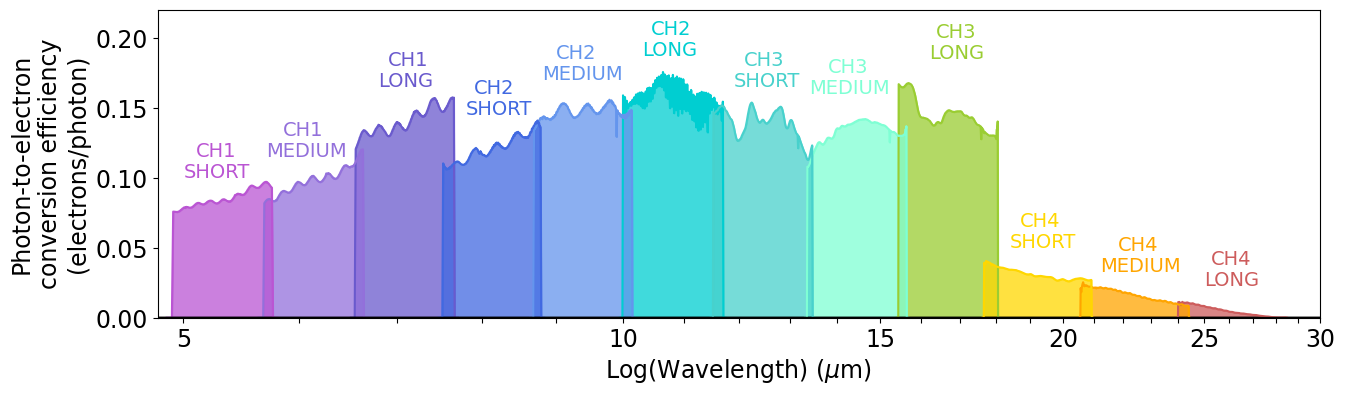

In [3]:
# ==========================================================================
# End-to-end throughput, including OTE and detector QE (PCE per photon)
# ==========================================================================

# Read in the OTE throughput file
fs = glob.glob(path + 'telescope/jwst_telescope_ote_thruput_20*')
ote = fits.open(fs[0])
ote_wav = ote[1].data['WAVELENGTH']
ote_thru = ote[1].data['THROUGHPUT']

# Read in the imager QE file
fs = glob.glob(path + 'miri/qe/*imager*')
img = fits.open(fs[0])
img_wav = img[1].data['WAVELENGTH']
img_qe = img[1].data['THROUGHPUT']

# ============
# MIRI Imaging
# ============

# Optical path: OTE throughput * filter transmission * imager QE

# Identify the filter transmission files
f = sorted(glob.glob(path + 'miri/filters/*w_*'))

# Set up the plot
plt.figure(figsize = (15, 4));
plt.xlabel('Wavelength ($\mu$m)');
plt.ylabel(textwrap.fill('Photon-to-electron conversion efficiency (electrons/photon)', width = 25));
plt.xlim([4.8, 30]);
plt.ylim([0, 0.55]);

# List of properties to loop over for the plot
colors = ['mediumorchid', 'mediumpurple', 'royalblue', 'cornflowerblue', 'darkturquoise', 'limegreen', 'yellowgreen', 'orange', 'indianred']
labels = ['F560W', 'F770W', 'F1000W', 'F1130W', 'F1280W', 'F1500W', 'F1800W', 'F2100W', 'F2550W']
x = [5, 7, 9, 11.2, 11.8, 14.3, 17, 20, 25]
y = [0.3, 0.4, 0.51, 0.48, 0.43, 0.5, 0.49, 0.4, 0.33]

# Loop over the filters, open the FITS files and pull out wavelength and throughput information
# Interpolate the OTE and detector QE throughputs onto the wavelength grid of the filter
# Compute the throughput and plot it
for i in range(len(f)):
    q = fits.open(f[i])
    fwav = q[1].data['WAVELENGTH']
    ftrans = q[1].data['THROUGHPUT']

    ote_interp = scipy.interpolate.interp1d(ote_wav, ote_thru, fill_value = 'extrapolate')
    ote_thru_trunc = ote_interp(fwav)

    qe_interp = scipy.interpolate.interp1d(img_wav, img_qe, fill_value = 'extrapolate')
    img_qe_trunc = qe_interp(fwav)
    
    thru = ftrans*ote_thru_trunc*img_qe_trunc

    # Create the FITS file w/ header information
    col1 = fits.Column(name = 'WAVELENGTH', format = '1D', unit = 'MICRONS', disp = 'F10.1', array = fwav)
    col2 = fits.Column(name = 'THROUGHPUT', format = '1D', unit = 'ELECTRONS/PHOTON', disp = 'G12.5', array = thru)

    cols = fits.ColDefs([col1,col2])
    hdu = fits.BinTableHDU.from_columns(cols)
    
    hdu.header['DATE'] = date
    hdu.header['AUTHOR'] = 'STScI MIRI Team'
    hdu.header['DESCRIP'] = 'MIRI Imager ' + labels[i] + ' end-to-end throughput (per photon)'
    hdu.header['HISTORY'] = 'Computed using Pandeia Data Version ' + vers
    hdu.header['HISTORY'] = 'Includes optical telescope element (OTE) transmission'
    hdu.header['HISTORY'] = 'Includes detector quantum efficiency (QE)'

    hdu.writeto(cwd + '/MIRI_endtoend_throughput_perphoton/MIRI_' + labels[i] + '_endtoend_throughput_perphoton_ETC' + vers + '.fits', overwrite = 'TRUE')

    plt.plot(fwav, thru, color = colors[i]);
    plt.fill_between(fwav, thru-0.002, color = colors[i], alpha = 0.75);
    plt.text(x[i], y[i], labels[i], fontsize = 14, color = colors[i]);
    plt.hlines(0.0, 4.8, 30, color = 'black');

plt.savefig(cwd + '/ETC' + vers + '/miri_img_pces_ETC' + vers + '.png', bbox_inches = 'tight', dpi = 300)

# ==========================
# MIRI Coronagraphic Imaging
# ==========================

# Optical path: OTE throughput * filter transmission * imager QE
# For coronagraphic imaging, the germanium coatings are included in the filter transmissions

# Identify the filter transmission files
f = sorted(glob.glob(path + 'miri/filters/*c_*'))

# Set up the plot
plt.figure(figsize = (15, 4));
plt.xlabel('Wavelength ($\mu$m)');
plt.ylabel(textwrap.fill('Photon-to-electron conversion efficiency (electrons/photon)', width = 25));
plt.xlim([4.8, 30]);
plt.ylim([0, 0.4]);

# List of properties to loop over for the plot
colors = ['mediumorchid', 'mediumpurple', 'mediumseagreen', 'indianred']
labels = ['F1065C', 'F1140C', 'F1550C', 'F2300C']
x = [8.6, 11.6, 15.7, 22]
y = [0.32, 0.35, 0.35, 0.34]

# Loop over the filters, open the FITS files and pull out wavelength and throughput information
# Interpolate the OTE and detector QE throughputs onto the wavelength grid of the filter
# Compute the throughput and plot it
for i in range(len(f)):
    q = fits.open(f[i])
    fwav = q[1].data['WAVELENGTH']
    ftrans = q[1].data['THROUGHPUT']

    ote_interp = scipy.interpolate.interp1d(ote_wav, ote_thru, fill_value = 'extrapolate')
    ote_thru_trunc = ote_interp(fwav)

    qe_interp = scipy.interpolate.interp1d(img_wav, img_qe, fill_value = 'extrapolate')
    img_qe_trunc = qe_interp(fwav)
    
    thru = ftrans*ote_thru_trunc*img_qe_trunc

    # Create the FITS file w/ header information
    col1 = fits.Column(name = 'WAVELENGTH', format = '1D', unit = 'MICRONS', disp = 'F10.1', array = fwav)
    col2 = fits.Column(name = 'THROUGHPUT', format = '1D', unit = 'ELECTRONS/PHOTON', disp = 'G12.5', array = thru)

    cols = fits.ColDefs([col1,col2])
    hdu = fits.BinTableHDU.from_columns(cols)
    
    hdu.header['DATE'] = date
    hdu.header['AUTHOR'] = 'STScI MIRI Team'
    hdu.header['DESCRIP'] = 'MIRI Coronagraphic Imaging ' + labels[i] + ' end-to-end throughput (per photon)'
    hdu.header['HISTORY'] = 'Computed using Pandeia Data Version ' + vers
    hdu.header['HISTORY'] = 'Includes optical telescope element (OTE) transmission'
    hdu.header['HISTORY'] = 'Includes detector quantum efficiency (QE)'

    hdu.writeto(cwd + '/MIRI_endtoend_throughput_perphoton/MIRI_' + labels[i] + '_endtoend_throughput_perphoton_ETC' + vers + '.fits', overwrite = 'TRUE')

    plt.plot(fwav, thru, color = colors[i]);
    plt.fill_between(fwav, thru-0.002, color = colors[i], alpha = 0.75);
    plt.text(x[i], y[i], labels[i], fontsize = 14, color = colors[i]);
    plt.hlines(0.0, 4.8, 30, color = 'black');

plt.savefig(cwd + '/ETC' + vers + '/miri_coron_img_pces_ETC' + vers + '.png', bbox_inches = 'tight', dpi = 300)

# ========================
# MIRI LRS Slit & Slitless
# ========================

# Optical path: OTE throughput * LRS slit/slitless spectral efficiency * imager QE

# Identify the LRS slit and slitless spectral efficiency files
f = sorted(glob.glob(path + 'miri/blaze/*p750l*'))

# Set up the plot
plt.figure(figsize = (7, 5));
plt.xlabel('Wavelength ($\mu$m)');
plt.ylabel(textwrap.fill('Photon-to-electron conversion efficiency (electrons/photon)', width = 25));
plt.xlim([3.9, 14.1]);
plt.ylim([0, 0.5]);

# List of properties to loop over for the plot
colors = ['tomato', 'dodgerblue']
labels = ['LRS Slitless', 'LRS Slit']
x = [10.7, 4.4]
y = [0.35, 0.38]

# Loop over the spectral efficiencies, open the FITS files and pull out wavelength and throughput information
# Interpolate the OTE and detector QE throughputs onto the wavelength grid of the spectral element
# Compute the throughput and plot it
for i in range(len(f)):
    q = fits.open(f[i])
    fwav = q[1].data['WAVELENGTH']
    ftrans = q[1].data['THROUGHPUT']

    ote_interp = scipy.interpolate.interp1d(ote_wav, ote_thru, fill_value = 'extrapolate')
    ote_thru_trunc = ote_interp(fwav)

    qe_interp = scipy.interpolate.interp1d(img_wav, img_qe, fill_value = 'extrapolate')
    img_qe_trunc = qe_interp(fwav)
    
    thru = ftrans*ote_thru_trunc*img_qe_trunc

    plt.plot(fwav, thru, color = colors[i]);
    plt.fill_between(fwav, thru-0.002, color = colors[i], alpha = 0.3);
    plt.text(x[i], y[i], labels[i], fontsize = 20, color = colors[i]);
    plt.hlines(0.0, 4.8, 30, color = 'black');

    # Create the FITS file w/ header information
    col1 = fits.Column(name = 'WAVELENGTH', format = '1D', unit = 'MICRONS', disp = 'F10.1', array = fwav)
    col2 = fits.Column(name = 'THROUGHPUT', format = '1D', unit = 'ELECTRONS/PHOTON', disp = 'G12.5', array = thru)

    cols = fits.ColDefs([col1,col2])
    hdu = fits.BinTableHDU.from_columns(cols)
    
    hdu.header['DATE'] = date
    hdu.header['AUTHOR'] = 'STScI MIRI Team'
    hdu.header['DESCRIP'] = 'MIRI ' + labels[i] + ' end-to-end throughput (per photon)'
    hdu.header['HISTORY'] = 'Computed using Pandeia Data Version ' + vers
    hdu.header['HISTORY'] = 'Includes optical telescope element (OTE) transmission'
    hdu.header['HISTORY'] = 'Includes detector quantum efficiency (QE)'

    z = labels[i].split()
    
    hdu.writeto(cwd + '/MIRI_endtoend_throughput_perphoton/MIRI_' + labels[i] + '_endtoend_throughput_perphoton_ETC' + vers + '.fits', overwrite = 'TRUE')
    
plt.savefig(cwd + '/ETC' + vers + '/miri_lrs_pces_ETC' + vers + '.png', bbox_inches = 'tight', dpi = 300)

# ========
# MIRI MRS
# ========

# Optical path: OTE throughput * MRS sub-band spectral efficiency * SW/LW QE
# Various reflections and transmissions through dichroics are included in the spectral efficiency files

# Read in the MRS detector QE files
fs = glob.glob(path + 'miri/qe/*sw*')
sw = fits.open(fs[0])
sw_qe_wav = sw[1].data['WAVELENGTH']
sw_qe = sw[1].data['THROUGHPUT']

fs = glob.glob(path + 'miri/qe/*lw*')
lw = fits.open(fs[0])
lw_qe_wav = lw[1].data['WAVELENGTH']
lw_qe = lw[1].data['THROUGHPUT']

# Identify the MRS sub-band spectral efficiency files
f = sorted(glob.glob(path + 'miri/blaze/*ch*'))

# Set up the plot
plt.figure(figsize = (15, 4));
plt.xlabel('Log(Wavelength) ($\mu$m)');
plt.ylabel(textwrap.fill('Photon-to-electron conversion efficiency (electrons/photon)', width = 25));
plt.xlim([4.8, 30])
plt.ylim([0, 0.22]);
plt.xscale('log');
plt.xticks(ticks = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], labels = [5, '', '', '', '',10, '', '', '', '', 15, '', '', '', '', 20, '', '', '', '', 25, '', '', '', '', 30])

# List of properties to loop over for the plot
colors = ['slateblue', 'mediumpurple', 'mediumorchid', 'darkturquoise', 'cornflowerblue', 'royalblue', 'yellowgreen', 'aquamarine', 'mediumturquoise', 'indianred', 'orange', 'gold']
labels1 = ['CH1', 'CH1', 'CH1', 'CH2', 'CH2', 'CH2', 'CH3', 'CH3', 'CH3', 'CH4', 'CH4', 'CH4']
x1 = [6.9, 5.85, 5.1, 10.45, 9.0, 7.9, 16.38, 13.8, 12.1, 25.25, 21.8, 18.7]
y1 = [0.18, 0.13, 0.115, 0.202, 0.185, 0.16, 0.20, 0.175, 0.18, 0.038, 0.048, 0.065]
labels2 = ['LONG', 'MEDIUM', 'SHORT', 'LONG', 'MEDIUM', 'SHORT', 'LONG', 'MEDIUM', 'SHORT', 'LONG', 'MEDIUM', 'SHORT']
x2 = [6.8, 5.7, 5.0, 10.3, 8.8, 7.8, 16.2, 13.4, 11.9, 25.0, 21.2, 18.4]
y2 = [0.165, 0.115, 0.1, 0.187, 0.17, 0.145, 0.185, 0.16, 0.165, 0.023, 0.033, 0.05]

# Loop over the spectral efficiencies, open the FITS files and pull out wavelength and throughput information
# Interpolate the OTE and detector QE throughputs onto the wavelength grid of the spectral element
# Compute the throughput and plot it
for i in range(len(f)):
    q = fits.open(f[i])
    fwav = q[1].data['WAVELENGTH']
    ftrans = q[1].data['THROUGHPUT']

    ote_interp = scipy.interpolate.interp1d(ote_wav, ote_thru, fill_value = 'extrapolate')
    ote_thru_trunc = ote_interp(fwav)

    if i <= 5:
        qe_interp = scipy.interpolate.interp1d(sw_qe_wav, sw_qe, fill_value = 'extrapolate')
        sw_qe_trunc = qe_interp(fwav)
        thru = ftrans*ote_thru_trunc*sw_qe_trunc

    if i > 5:
        qe_interp = scipy.interpolate.interp1d(lw_qe_wav, lw_qe, fill_value = 'extrapolate')
        lw_qe_trunc = qe_interp(fwav)
        thru = ftrans*ote_thru_trunc*lw_qe_trunc        

    plt.plot(fwav, thru, color = colors[i]);
    plt.fill_between(fwav, thru, color = colors[i], alpha = 0.75);
    plt.text(x1[i], y1[i], labels1[i], fontsize = 14, color = colors[i]);
    plt.text(x2[i], y2[i], labels2[i], fontsize = 14, color = colors[i]);
    plt.hlines(0.0, 4.8, 30, color = 'black');

    # Create the FITS file w/ header information
    col1 = fits.Column(name = 'WAVELENGTH', format = '1D', unit = 'MICRONS', disp = 'F10.1', array = fwav)
    col2 = fits.Column(name = 'THROUGHPUT', format = '1D', unit = 'ELECTRONS/PHOTON', disp = 'G12.5', array = thru)

    cols = fits.ColDefs([col1,col2])
    hdu = fits.BinTableHDU.from_columns(cols)
    
    hdu.header['DATE'] = date
    hdu.header['AUTHOR'] = 'STScI MIRI Team'
    hdu.header['DESCRIP'] = 'MIRI MRS ' + labels1[i] + ' ' + labels2[i] + ' end-to-end throughput (per photon)'
    hdu.header['HISTORY'] = 'Computed using Pandeia Data Version ' + vers
    hdu.header['HISTORY'] = 'Includes optical telescope element (OTE) transmission'
    hdu.header['HISTORY'] = 'Includes detector quantum efficiency (QE)'

    hdu.writeto(cwd + '/MIRI_endtoend_throughput_perphoton/MIRI_' + labels1[i] + '_' + labels2[i] + '_endtoend_throughput_perphoton_ETC' + vers + '.fits', overwrite = 'TRUE')

plt.savefig(cwd + '/ETC' + vers + '/miri_mrs_pces_ETC' + vers + '.png', bbox_inches = 'tight', dpi = 300)


In [4]:
# ========================================================
# Unitless transmission, including OTE but not detector QE
# ========================================================

# Read in the OTE throughput file
fs = glob.glob(path + 'telescope/jwst_telescope_ote_thruput_20*')
ote = fits.open(fs[0])
ote_wav = ote[1].data['WAVELENGTH']
ote_thru = ote[1].data['THROUGHPUT']

# ============
# MIRI Imaging
# ============

# Optical path: OTE throughput * filter transmission

# Identify the filter transmission files
f = sorted(glob.glob(path + 'miri/filters/*w_*'))
labels = ['F560W', 'F770W', 'F1000W', 'F1130W', 'F1280W', 'F1500W', 'F1800W', 'F2100W', 'F2550W']

# Loop over the filters, open the FITS files and pull out wavelength and throughput information
# Interpolate the OTE throughput onto the wavelength grid of the filter
# Compute the transmission
for i in range(len(f)):
    q = fits.open(f[i])
    fwav = q[1].data['WAVELENGTH']
    ftrans = q[1].data['THROUGHPUT']

    ote_interp = scipy.interpolate.interp1d(ote_wav, ote_thru, fill_value = 'extrapolate')
    ote_thru_trunc = ote_interp(fwav)
    
    thru = ftrans*ote_thru_trunc

    # Create the FITS file w/ header information
    col1 = fits.Column(name = 'WAVELENGTH', format = '1D', unit = 'MICRONS', disp = 'F10.1', array = fwav)
    col2 = fits.Column(name = 'TRANSMISSION', format = '1D', unit = 'UNITLESS', disp = 'G12.5', array = thru)

    cols = fits.ColDefs([col1,col2])
    hdu = fits.BinTableHDU.from_columns(cols)
    
    hdu.header['DATE'] = date
    hdu.header['AUTHOR'] = 'STScI MIRI Team'
    hdu.header['DESCRIP'] = 'MIRI Imager ' + labels[i] + ' transmission'
    hdu.header['HISTORY'] = 'Computed using Pandeia Data Version ' + vers
    hdu.header['HISTORY'] = 'Includes optical telescope element (OTE) transmission'
    hdu.header['HISTORY'] = 'Does not include detector quantum efficiency (QE)'

    hdu.writeto(cwd + '/MIRI_transmission/MIRI_' + labels[i] + '_transmission_ETC' + vers + '.fits', overwrite = 'TRUE')

# ==========================
# MIRI Coronagraphic Imaging
# ==========================

# Optical path: OTE throughput * filter transmission
# For coronagraphic imaging, the germanium coatings are included in the filter transmissions

# Identify the filter transmission files
f = sorted(glob.glob(path + 'miri/filters/*c_*'))
labels = ['F1065C', 'F1140C', 'F1550C', 'F2300C']

# Loop over the filters, open the FITS files and pull out wavelength and throughput information
# Interpolate the OTE throughput onto the wavelength grid of the filter
# Compute the transmission
for i in range(len(f)):
    q = fits.open(f[i])
    fwav = q[1].data['WAVELENGTH']
    ftrans = q[1].data['THROUGHPUT']

    ote_interp = scipy.interpolate.interp1d(ote_wav, ote_thru, fill_value = 'extrapolate')
    ote_thru_trunc = ote_interp(fwav)
    
    thru = ftrans*ote_thru_trunc

    # Create the FITS file w/ header information
    col1 = fits.Column(name = 'WAVELENGTH', format = '1D', unit = 'MICRONS', disp = 'F10.1', array = fwav)
    col2 = fits.Column(name = 'TRANSMISSION', format = '1D', unit = 'UNITLESS', disp = 'G12.5', array = thru)

    cols = fits.ColDefs([col1,col2])
    hdu = fits.BinTableHDU.from_columns(cols)
    
    hdu.header['DATE'] = date
    hdu.header['AUTHOR'] = 'STScI MIRI Team'
    hdu.header['DESCRIP'] = 'MIRI Coronagraphic Imaging ' + labels[i] + ' transmission'
    hdu.header['HISTORY'] = 'Computed using Pandeia Data Version ' + vers
    hdu.header['HISTORY'] = 'Includes optical telescope element (OTE) transmission'
    hdu.header['HISTORY'] = 'Does not include detector quantum efficiency (QE)'

    hdu.writeto(cwd + '/MIRI_transmission/MIRI_' + labels[i] + '_transmission_ETC' + vers + '.fits', overwrite = 'TRUE')

# ========================
# MIRI LRS Slit & Slitless
# ========================

# Optical path: OTE throughput * LRS slit/slitless spectral efficiency

# Identify the LRS slit and slitless spectral efficiency files
f = sorted(glob.glob(path + 'miri/blaze/*p750l*'))
labels = ['LRS Slitless', 'LRS Slit']

# Loop over the spectral efficiencies, open the FITS files and pull out wavelength and throughput information
# Interpolate the OTE throughput onto the wavelength grid of the spectral element
# Compute the transmission
for i in range(len(f)):
    q = fits.open(f[i])
    fwav = q[1].data['WAVELENGTH']
    ftrans = q[1].data['THROUGHPUT']

    ote_interp = scipy.interpolate.interp1d(ote_wav, ote_thru, fill_value = 'extrapolate')
    ote_thru_trunc = ote_interp(fwav)
    
    thru = ftrans*ote_thru_trunc

    # Create the FITS file w/ header information
    col1 = fits.Column(name = 'WAVELENGTH', format = '1D', unit = 'MICRONS', disp = 'F10.1', array = fwav)
    col2 = fits.Column(name = 'TRANSMISSION', format = '1D', unit = 'UNITLESS', disp = 'G12.5', array = thru)

    cols = fits.ColDefs([col1,col2])
    hdu = fits.BinTableHDU.from_columns(cols)
    
    hdu.header['DATE'] = date
    hdu.header['AUTHOR'] = 'STScI MIRI Team'
    hdu.header['DESCRIP'] = 'MIRI ' + labels[i] + ' transmission'
    hdu.header['HISTORY'] = 'Computed using Pandeia Data Version ' + vers
    hdu.header['HISTORY'] = 'Includes optical telescope element (OTE) transmission'
    hdu.header['HISTORY'] = 'Does not include detector quantum efficiency (QE)'

    z = labels[i].split()
    
    hdu.writeto(cwd + '/MIRI_transmission/MIRI_' + labels[i] + '_transmission_ETC' + vers + '.fits', overwrite = 'TRUE')

# ========
# MIRI MRS
# ========

# Optical path: OTE throughput * MRS sub-band spectral efficiency
# Various reflections and transmissions through dichroics are included in the spectral efficiency files

# Identify the MRS sub-band spectral efficiency files
f = sorted(glob.glob(path + 'miri/blaze/*ch*'))
labels1 = ['CH1', 'CH1', 'CH1', 'CH2', 'CH2', 'CH2', 'CH3', 'CH3', 'CH3', 'CH4', 'CH4', 'CH4']
labels2 = ['LONG', 'MEDIUM', 'SHORT', 'LONG', 'MEDIUM', 'SHORT', 'LONG', 'MEDIUM', 'SHORT', 'LONG', 'MEDIUM', 'SHORT']

# Loop over the spectral efficiencies, open the FITS files and pull out wavelength and throughput information
# Interpolate the OTE throughput onto the wavelength grid of the spectral element
# Compute the transmission
for i in range(len(f)):
    q = fits.open(f[i])
    fwav = q[1].data['WAVELENGTH']
    ftrans = q[1].data['THROUGHPUT']

    ote_interp = scipy.interpolate.interp1d(ote_wav, ote_thru, fill_value = 'extrapolate')
    ote_thru_trunc = ote_interp(fwav)

    thru = ftrans*ote_thru_trunc 

    # Create the FITS file w/ header information
    col1 = fits.Column(name = 'WAVELENGTH', format = '1D', unit = 'MICRONS', disp = 'F10.1', array = fwav)
    col2 = fits.Column(name = 'TRANSMISSION', format = '1D', unit = 'UNITLESS', disp = 'G12.5', array = thru)

    cols = fits.ColDefs([col1,col2])
    hdu = fits.BinTableHDU.from_columns(cols)
    
    hdu.header['DATE'] = date
    hdu.header['AUTHOR'] = 'STScI MIRI Team'
    hdu.header['DESCRIP'] = 'MIRI MRS ' + labels1[i] + ' ' + labels2[i] + ' transmission'
    hdu.header['HISTORY'] = 'Computed using Pandeia Data Version ' + vers
    hdu.header['HISTORY'] = 'Includes optical telescope element (OTE) transmission'
    hdu.header['HISTORY'] = 'Does not include detector quantum efficiency (QE)'

    hdu.writeto(cwd + '/MIRI_transmission/MIRI_' + labels1[i] + '_' + labels2[i] + '_transmission_ETC' + vers + '.fits', overwrite = 'TRUE')


In [5]:
# ==========================================================================
# End-to-end throughput, including OTE and detector QE (PCE per energy)
# ==========================================================================

# Define Planck's constant in J s
hpc = 6.62607015e-34

# Define speed of light in micron/s
csl = 2.99792458e14

# Read in the OTE throughput file
fs = glob.glob(path + 'telescope/jwst_telescope_ote_thruput_20*')
ote = fits.open(fs[0])
ote_wav = ote[1].data['WAVELENGTH']
ote_thru = ote[1].data['THROUGHPUT']

# Read in the imager QE file
fs = glob.glob(path + 'miri/qe/*imager*')
img = fits.open(fs[0])
img_wav = img[1].data['WAVELENGTH']
img_qe = img[1].data['THROUGHPUT']

# ============
# MIRI Imaging
# ============

# Optical path: OTE throughput * filter transmission * imager QE

# Identify the filter transmission files
f = sorted(glob.glob(path + 'miri/filters/*w_*'))
labels = ['F560W', 'F770W', 'F1000W', 'F1130W', 'F1280W', 'F1500W', 'F1800W', 'F2100W', 'F2550W']

# Loop over the filters, open the FITS files and pull out wavelength and throughput information
# Interpolate the OTE and detector QE throughputs onto the wavelength grid of the filter
# Compute the throughput and divide by the photon energy in that wavelength bin
for i in range(len(f)):
    q = fits.open(f[i])
    fwav = q[1].data['WAVELENGTH']
    ftrans = q[1].data['THROUGHPUT']

    ote_interp = scipy.interpolate.interp1d(ote_wav, ote_thru, fill_value = 'extrapolate')
    ote_thru_trunc = ote_interp(fwav)

    qe_interp = scipy.interpolate.interp1d(img_wav, img_qe, fill_value = 'extrapolate')
    img_qe_trunc = qe_interp(fwav)
    
    thru = ftrans*ote_thru_trunc*img_qe_trunc/(hpc*csl/fwav)

    # Create the FITS file w/ header information
    col1 = fits.Column(name = 'WAVELENGTH', format = '1D', unit = 'MICRONS', disp = 'F10.1', array = fwav)
    col2 = fits.Column(name = 'THROUGHPUT', format = '1D', unit = 'ELECTRONS/JOULE', disp = 'G12.5', array = thru)

    cols = fits.ColDefs([col1,col2])
    hdu = fits.BinTableHDU.from_columns(cols)
    
    hdu.header['DATE'] = date
    hdu.header['AUTHOR'] = 'STScI MIRI Team'
    hdu.header['DESCRIP'] = 'MIRI Imager ' + labels[i] + ' end-to-end throughput (per energy)'
    hdu.header['HISTORY'] = 'Computed using Pandeia Data Version ' + vers
    hdu.header['HISTORY'] = 'Includes optical telescope element (OTE) transmission'
    hdu.header['HISTORY'] = 'Includes detector quantum efficiency (QE)'

    hdu.writeto(cwd + '/MIRI_endtoend_throughput_perenergy/MIRI_' + labels[i] + '_endtoend_throughput_perenergy_ETC' + vers + '.fits', overwrite = 'TRUE')

# ==========================
# MIRI Coronagraphic Imaging
# ==========================

# Optical path: OTE throughput * filter transmission * imager QE
# For coronagraphic imaging, the germanium coatings are included in the filter transmissions

# Identify the filter transmission files
f = sorted(glob.glob(path + 'miri/filters/*c_*'))
labels = ['F1065C', 'F1140C', 'F1550C', 'F2300C']

# Loop over the filters, open the FITS files and pull out wavelength and throughput information
# Interpolate the OTE and detector QE throughputs onto the wavelength grid of the filter
# Compute the throughput and divide by the photon energy in that wavelength bin
for i in range(len(f)):
    q = fits.open(f[i])
    fwav = q[1].data['WAVELENGTH']
    ftrans = q[1].data['THROUGHPUT']

    ote_interp = scipy.interpolate.interp1d(ote_wav, ote_thru, fill_value = 'extrapolate')
    ote_thru_trunc = ote_interp(fwav)

    qe_interp = scipy.interpolate.interp1d(img_wav, img_qe, fill_value = 'extrapolate')
    img_qe_trunc = qe_interp(fwav)
    
    thru = ftrans*ote_thru_trunc*img_qe_trunc/(hpc*csl/fwav)

    # Create the FITS file w/ header information
    col1 = fits.Column(name = 'WAVELENGTH', format = '1D', unit = 'MICRONS', disp = 'F10.1', array = fwav)
    col2 = fits.Column(name = 'THROUGHPUT', format = '1D', unit = 'ELECTRONS/JOULE', disp = 'G12.5', array = thru)

    cols = fits.ColDefs([col1,col2])
    hdu = fits.BinTableHDU.from_columns(cols)
    
    hdu.header['DATE'] = date
    hdu.header['AUTHOR'] = 'STScI MIRI Team'
    hdu.header['DESCRIP'] = 'MIRI Coronagraphic Imaging ' + labels[i] + ' end-to-end throughput (per energy)'
    hdu.header['HISTORY'] = 'Computed using Pandeia Data Version ' + vers
    hdu.header['HISTORY'] = 'Includes optical telescope element (OTE) transmission'
    hdu.header['HISTORY'] = 'Includes detector quantum efficiency (QE)'

    hdu.writeto(cwd + '/MIRI_endtoend_throughput_perenergy/MIRI_' + labels[i] + '_endtoend_throughput_perenergy_ETC' + vers + '.fits', overwrite = 'TRUE')

# ========================
# MIRI LRS Slit & Slitless
# ========================

# Optical path: OTE throughput * LRS slit/slitless spectral efficiency * imager QE

# Identify the LRS slit and slitless spectral efficiency files
f = sorted(glob.glob(path + 'miri/blaze/*p750l*'))
labels = ['LRS Slitless', 'LRS Slit']

# Loop over the spectral efficiencies, open the FITS files and pull out wavelength and throughput information
# Interpolate the OTE and detector QE throughputs onto the wavelength grid of the spectral element
# Compute the throughput and divide by the photon energy in that wavelength bin
for i in range(len(f)):
    q = fits.open(f[i])
    fwav = q[1].data['WAVELENGTH']
    ftrans = q[1].data['THROUGHPUT']

    ote_interp = scipy.interpolate.interp1d(ote_wav, ote_thru, fill_value = 'extrapolate')
    ote_thru_trunc = ote_interp(fwav)

    qe_interp = scipy.interpolate.interp1d(img_wav, img_qe, fill_value = 'extrapolate')
    img_qe_trunc = qe_interp(fwav)
    
    thru = ftrans*ote_thru_trunc*img_qe_trunc/(hpc*csl/fwav)

    # Create the FITS file w/ header information
    col1 = fits.Column(name = 'WAVELENGTH', format = '1D', unit = 'MICRONS', disp = 'F10.1', array = fwav)
    col2 = fits.Column(name = 'THROUGHPUT', format = '1D', unit = 'ELECTRONS/JOULE', disp = 'G12.5', array = thru)

    cols = fits.ColDefs([col1,col2])
    hdu = fits.BinTableHDU.from_columns(cols)
    
    hdu.header['DATE'] = date
    hdu.header['AUTHOR'] = 'STScI MIRI Team'
    hdu.header['DESCRIP'] = 'MIRI ' + labels[i] + ' end-to-end throughput (per energy)'
    hdu.header['HISTORY'] = 'Computed using Pandeia Data Version ' + vers
    hdu.header['HISTORY'] = 'Includes optical telescope element (OTE) transmission'
    hdu.header['HISTORY'] = 'Includes detector quantum efficiency (QE)'

    z = labels[i].split()
    
    hdu.writeto(cwd + '/MIRI_endtoend_throughput_perenergy/MIRI_' + labels[i] + '_endtoend_throughput_perenergy_ETC' + vers + '.fits', overwrite = 'TRUE')

# ========
# MIRI MRS
# ========

# Optical path: OTE throughput * MRS sub-band spectral efficiency * SW/LW QE
# Various reflections and transmissions through dichroics are included in the spectral efficiency files

# Read in the MRS detector QE files
fs = glob.glob(path + 'miri/qe/*sw*')
sw = fits.open(fs[0])
sw_qe_wav = sw[1].data['WAVELENGTH']
sw_qe = sw[1].data['THROUGHPUT']

fs = glob.glob(path + 'miri/qe/*lw*')
lw = fits.open(fs[0])
lw_qe_wav = lw[1].data['WAVELENGTH']
lw_qe = lw[1].data['THROUGHPUT']

# Identify the MRS sub-band spectral efficiency files
f = sorted(glob.glob(path + 'miri/blaze/*ch*'))

# Identify the MRS sub-band spectral efficiency files
f = sorted(glob.glob(path + 'miri/blaze/*ch*'))
labels1 = ['CH1', 'CH1', 'CH1', 'CH2', 'CH2', 'CH2', 'CH3', 'CH3', 'CH3', 'CH4', 'CH4', 'CH4']
labels2 = ['LONG', 'MEDIUM', 'SHORT', 'LONG', 'MEDIUM', 'SHORT', 'LONG', 'MEDIUM', 'SHORT', 'LONG', 'MEDIUM', 'SHORT']

# Loop over the spectral efficiencies, open the FITS files and pull out wavelength and throughput information
# Interpolate the OTE and detector QE throughputs onto the wavelength grid of the spectral element
# Compute the throughput and divide by the photon energy in that wavelength bin
for i in range(len(f)):
    q = fits.open(f[i])
    fwav = q[1].data['WAVELENGTH']
    ftrans = q[1].data['THROUGHPUT']

    ote_interp = scipy.interpolate.interp1d(ote_wav, ote_thru, fill_value = 'extrapolate')
    ote_thru_trunc = ote_interp(fwav)

    if i <= 5:
        qe_interp = scipy.interpolate.interp1d(sw_qe_wav, sw_qe, fill_value = 'extrapolate')
        sw_qe_trunc = qe_interp(fwav)
        thru = ftrans*ote_thru_trunc*sw_qe_trunc/(hpc*csl/fwav)

    if i > 5:
        qe_interp = scipy.interpolate.interp1d(lw_qe_wav, lw_qe, fill_value = 'extrapolate')
        lw_qe_trunc = qe_interp(fwav)
        thru = ftrans*ote_thru_trunc*lw_qe_trunc/(hpc*csl/fwav)      

    # Create the FITS file w/ header information
    col1 = fits.Column(name = 'WAVELENGTH', format = '1D', unit = 'MICRONS', disp = 'F10.1', array = fwav)
    col2 = fits.Column(name = 'THROUGHPUT', format = '1D', unit = 'ELECTRONS/JOULE', disp = 'G12.5', array = thru)

    cols = fits.ColDefs([col1,col2])
    hdu = fits.BinTableHDU.from_columns(cols)
    
    hdu.header['DATE'] = date
    hdu.header['AUTHOR'] = 'STScI MIRI Team'
    hdu.header['DESCRIP'] = 'MIRI MRS ' + labels1[i] + ' ' + labels2[i] + ' end-to-end throughput (per energy)'
    hdu.header['HISTORY'] = 'Computed using Pandeia Data Version ' + vers
    hdu.header['HISTORY'] = 'Includes optical telescope element (OTE) transmission'
    hdu.header['HISTORY'] = 'Includes detector quantum efficiency (QE)'

    hdu.writeto(cwd + '/MIRI_endtoend_throughput_perenergy/MIRI_' + labels1[i] + '_' + labels2[i] + '_endtoend_throughput_perenergy_ETC' + vers + '.fits', overwrite = 'TRUE')
